In [196]:
import pandas as pd
import tskit as tsk
import numpy as np
from multiprocessing import Pool
from datetime import datetime
import json
import os

%run -i "../isRecipMonophyletic.py" # TO DEFINE NEW FUNCTION

perFile = True

if (perFile) :
    inputdir = '../../data/real/'
    inputs = [ # List of input .trees files
        # "Cgale_182222_dated.trees",
        "Cgale_87_dated.trees",
        # "Cgale_952_dated.trees"
    ]
else :
    inputdir = 'B:\\storage\\general-elias\\Code\\TS_FILES'
    inputs = os.listdir(inputdir) # List of input .trees files

startTime = datetime.now() # For performance measurement

In [197]:
def loadFile(filename) : # Does all the necessary imports on a single file
    sqObj = tsk.load(inputdir + filename)

    populations = str(sqObj.tables.populations.asdict()) # For later check, see cell 4

    pop_by_node = pd.DataFrame({ # Only one of these will be kept, thus the check above
        "pop": [sqObj.tables.nodes[leaf].population for leaf in sqObj.samples()], # Get the population of each leaf
    })

    # Create standalone pandas DataFrame for easier manipulation of data than tskit's tables...

    pd_sequence = pd.DataFrame(
        {
            'file': filename, # Gets the originating filename for future reference
            'span': [tree.span for tree in sqObj.trees()],
            'bounds': [(tree.interval.left, tree.interval.right) for tree in sqObj.trees()], # Loads the tree's bound in a tuple
            'treeObj' : sqObj.aslist()
        },
        index=[tree.index for tree in sqObj.trees()]
    )

    return sqObj, populations, pop_by_node, pd_sequence # All the information needed from a tree sequence

In [198]:
files = pd.DataFrame({ # Initiates the DataFrame with the input files
    'file': inputs,
})

# Fill the files DataFrame with the necessary information
files[['sqObj', 'populations', 'pop_by_node', 'pd_sequence']] = files.apply(lambda row: loadFile(row['file']), axis=1, result_type="expand")

In [199]:
# *The* check I was talking about earlier. If the populations are not the same, that's a problem...
if files.populations.nunique() != 1:
    raise ValueError("All the files do not have the same populations. Are you sure this is the same species ?")
else :
    pop_by_node = files.pop_by_node[0]

In [200]:
pop_groups = [ # Group the populations according to real data
    [0, 1], 
    [2, 3]
]

In [201]:
# TOOL FOR AUTOMATIC COLORING (I know, it shouldn't really be here...)

# Define a list of predefined colors
predefined_colors = ["red", "blue", "green", "yellow", "orange", "purple", "brown", "pink"] # Maximum 8 populations...

# Initialize node_colours dictionary
node_colours = {}

# Example :
exSq = files.iloc[0].sqObj

for node_index, node in enumerate(exSq.tables.nodes):
    if (node.flags & tsk.NODE_IS_SAMPLE) != 0: # If node is a sample
        
        # Assign color from predefined list, cycling through colors if necessary
        color = predefined_colors[node.population % len(predefined_colors)]
        node_colours[node_index] = color



In [202]:
# Generates a global pd_sequence from all the files to treat them as one.
globalTS = pd.concat(files.pd_sequence.to_list(), ignore_index=True)

### Bootstrap approach for statistics

In [203]:
%run -i "../isRecipMonophyletic.py" # TO DEFINE NEW FUNCTION

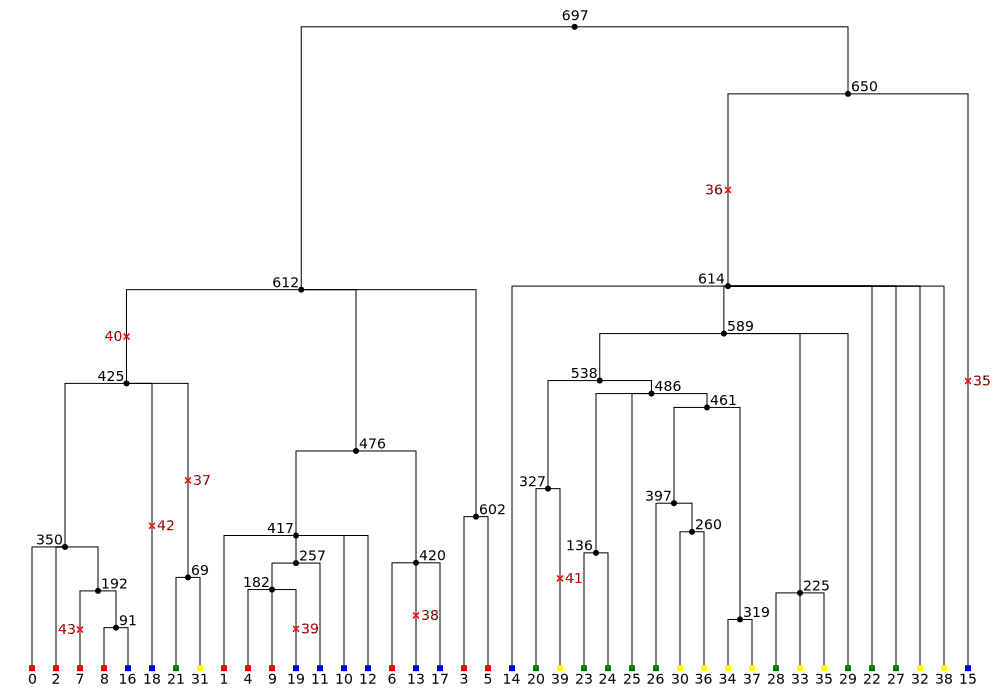

In [204]:
globalTS.loc[2].treeObj.draw(width=1000, height=700, node_colours=node_colours)

In [ ]:
def isRecipMonophyletic(tree, pop_by_node, pop_groups, boolean=True) :

    nodes_by_pop = pd.DataFrame(columns=['nodes', 'optimalGroup']) # This will be the list of leaves per population

    for root in tree.roots:
        for leaf in tree.leaves(root):

            current_pop = pop_by_node.loc[leaf, 'pop'] # Get the current leaf's population

            if (current_pop not in nodes_by_pop.index):
                nodes_by_pop.loc[current_pop, 'nodes'] = set() # Create a new entry for the population
                # Set type is important here because it is unordered, so when comparing the list of nodes, order isn't important
            nodes_by_pop.at[current_pop, 'nodes'].add(leaf) # Add the leaf to the population
    
    for pop_group in pop_groups:
        nodes_by_pop.loc[pop_group[0], 'nodes'] = nodes_by_pop.loc[pop_group[0], 'nodes'].union(nodes_by_pop.loc[pop_group[1], 'nodes']) # Combine the two populations according to the defined population groups
        # nodes_by_pop.at[pop_group[0], 'equivalentPops'] = pop_group # Store the equivalent populations for future reference
        nodes_by_pop.drop(pop_group[1], inplace=True)
    nodes_by_pop.reset_index(drop=True, inplace=True)

    # First level analysis : boolean check if the populations are reciprocally monophyletic
    nodes_by_pop['mrca'] = nodes_by_pop['nodes'].apply(lambda x: tree.mrca(*x)) # Identify the MRCA of the population's leaves
    nodes_by_pop['toplevelChildren'] = nodes_by_pop['mrca'].apply(lambda x: set(tree.leaves(x))) # Identify the MRCA's children

    # If each population's MRCA's children are the same as the population's leaves, all populations are reciprocally monophyletic
    nodes_by_pop['isMonophyletic'] = nodes_by_pop['nodes'] == nodes_by_pop['toplevelChildren']
    if nodes_by_pop['isMonophyletic'].all():
        return float(1)
    
    elif not (boolean):
        
        # Second level analysis (optional) : return detailed score that quantifies how monophyletic the populations are
        startNode = tree.parent(nodes_by_pop['mrca'].max()) if nodes_by_pop['mrca'].max() not in tree.roots else nodes_by_pop['mrca'].max()
        gloLeaves = set(tree.leaves(startNode))
        visitStack = [startNode]
        while len(visitStack) > 0 :
            currentNode = visitStack.pop()
            foundOptimal = False
            if currentNode == startNode or (currentNode not in nodes_by_pop['mrca'].values):
                currentLeaves = set(tree.leaves(currentNode))
                for pop in nodes_by_pop.index:
                    if (currentLeaves.issubset(nodes_by_pop.loc[pop, 'nodes'])):
                        if pd.isna(nodes_by_pop.at[pop, 'optimalGroup']) or len(currentLeaves) > len(nodes_by_pop.at[pop, 'optimalGroup']):
                            nodes_by_pop.at[pop, 'optimalGroup'] = currentLeaves
                        foundOptimal = True
                        break
            else :
                foundOptimal = True
            if not foundOptimal :
                for child in tree.children(currentNode):
                    if child not in gloLeaves:
                        visitStack.append(child)
        nodes_by_pop['rebels'] = (nodes_by_pop['nodes'] - nodes_by_pop['optimalGroup']).apply(lambda x: set() if pd.isna(x) else x)

        # return float(1 - nodes_by_pop['rebels'].apply(lambda x: len(x)).sum() / len(list(tree.samples())))
        return nodes_by_pop
    else :
        return float(0)

In [209]:
isRecipMonophyletic(globalTS.loc[2].treeObj, pop_by_node, pop_groups, False)

,nodes,optimalGroup,mrca,toplevelChildren,isMonophyletic,rebels
0,"{20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","{33, 34, 35, 36, 37, 39, 20, 23, 24, 25, 26, 2...",697,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,"{32, 38, 21, 22, 27, 31}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{1, 4, 6, 9, 10, 11, 12, 13, 17, 19}",697,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,"{0, 2, 3, 5, 7, 8, 14, 15, 16, 18}"


In [ ]:
n_threads = 1 # Threads to use for multiprocessing, 1 means no multiprocessing
n_samples = 1 # 1 means no bootstrapping

def f(i) : # Define util to be run in parallel
    np.random.seed(i + np.random.randint(0, 10000)) # Necessary, because otherwise all workers will have the same seed
    bootstrap = globalTS.sample(n=int(len(globalTS) * 0.9), replace=True) # Use pandas sample method to take random trees in the sequence for monophyly test
    bootstrap['monophyletic'] = bootstrap.apply(lambda x: isRecipMonophyletic(x.treeObj, pop_by_node, pop_groups), axis=1) # Runs the test
    return bootstrap[bootstrap['monophyletic'] == True]['span'].sum() / bootstrap['span'].sum() # Gets the percentage of the sample trees that is monophyletic

if n_threads > 1 :
    pool = Pool(n_threads) # Create a pool of 2 workers
    percentages = np.array(pool.map(f, range(n_samples))) * 100 # Run bootstrap n_samples times in parallel
elif n_threads == 1 :
    percentages = np.array(list(map(f, range(n_samples)))) * 100
else :
    raise ValueError("ERROR | n_threads = " + n_threads + " | Cannot perform operation with less than 1 thread !")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Monophyly test for the output

In [21]:
# Runs the reciprocally monophyletic test on each tree and saves the boolean result in the monophyletic column

globalTS['monophyletic'] = globalTS.apply(lambda x: isRecipMonophyletic(x.treeObj, pop_by_node, pop_groups), axis=1)
singlepercentage = globalTS[globalTS['monophyletic'] == True]['span'].sum() / globalTS['span'].sum() * 100

### Export results

In [ ]:
# Export sampling data

if n_samples > 0 :
    sampling = {
        "meanSamplesPercentage": percentages.mean(),
        "samplesStdDev": percentages.std(),
        "confidence_interval": {
            "bounds": [5, 95],
            "lower": np.percentile(percentages, 5),
            "upper": np.percentile(percentages, 95)
        },
    }
else :
    sampling = {}

In [23]:
endTime = datetime.now()

In [ ]:
# Define output file format

output = {
    "input": {
        "dir": inputdir,
        "files": inputs
    },
    "test": "reciprocal_monophyly",
    "description": "Reciprocal monophyly test on the tree sequence",
    "analysis_settings": {
        "bootstrap_samples": n_samples,
        "pop_groups": pop_groups,
    },
    "perf" : {
        "multiprocessing": n_threads > 1,
        "threads": n_threads,
        "start": startTime,
        "end": endTime,
        "duration": endTime - startTime
    },
    "result": {
        "sampling": sampling,
        "raw": {
            "positive": int((globalTS['monophyletic'] == True).sum()),
            "negative": int((globalTS['monophyletic'] == False).sum()),
            "total_trees": len(globalTS),
            "percentage": singlepercentage,
            "details": globalTS[['file', 'bounds', 'span', 'monophyletic']].to_dict(orient='records')
        },
    }
}

In [25]:
json.dump(output, default=str, indent=4, fp=open("../../data/out/reciprocal_monophyly_result.json", "w"))